In [1]:
import io
import os
import torch
import base64
import sqlite3
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset

In [2]:
CURR_PATH = os.getcwd()
PROJECT_PATH = os.path.dirname(CURR_PATH)
DATA_PATH = os.path.join(PROJECT_PATH, 'data')
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
TEST_PATH = os.path.join(DATA_PATH, 'test')
RES_PATH = os.path.join(PROJECT_PATH, 'res')
MODELS_PATH = os.path.join(PROJECT_PATH, 'models')
RLHF_PATH = os.path.join(DATA_PATH, 'RLHF.db')

# Check if GPU is available, and set the device accordingly
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# check folder is exist, if not then create folder
def check_path(folderPaths:list):
    for folderPath in folderPaths:
        if not os.path.exists(folderPath):
            os.makedirs(folderPath)

In [4]:
# check path
check_path([
    TRAIN_PATH, TEST_PATH,
])

In [5]:
# download training & test data and put in DATA_PATH
mnist_trainset = datasets.MNIST(
    root=TRAIN_PATH, 
    train=True, 
    download=True, 
    transform=ToTensor()
)

mnist_testset = datasets.MNIST(
    root=TEST_PATH, 
    train=False, 
    download=True, 
    transform=ToTensor()
)

In [6]:
# Data Prep
train_dataloader = DataLoader(
    mnist_trainset, 
    batch_size=20, 
    shuffle=True, 
    num_workers=0,
    pin_memory=True
)

test_dataloader = DataLoader(
    mnist_testset, 
    batch_size=20, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # First Convolutional Layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        
        # Second Convolutional Layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        
        # Fully Connected Layer for Classification
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        # Forward pass through the first convolutional layer
        x = self.conv1(x)
        
        # Forward pass through the second convolutional layer
        x = self.conv2(x)
        
        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)  # flattening the layer      
        
        # Forward pass through the fully connected layer for classification
        output = self.out(x)
        
        return output

In [8]:
def calculate_accuracy(model_output, target):
    # get the prediction
    predictions = torch.max(model_output, 1)[1].data.squeeze()
    
    # get the accuracy
    accuracy = (predictions == target).sum().item()/float(target.size(0))
    return accuracy

In [9]:
# Instantiate the CNN model and move it to the specified device (GPU or CPU)
cnn_model = CNN().to(device)

# Define the loss function (cross-entropy) - for classification problem
loss_function = nn.CrossEntropyLoss()

# Define the optimizer (Adam) for updating the model parameters during training
optimizer = optim.Adam(cnn_model.parameters(), lr=0.005)

In [10]:
# # model training 
# cnn_model.train()

# for epoch in range(10):
    
#     epoch_loss = 0
#     epoch_accuracy = 0
#     i = 0
#     for i, (images, labels) in enumerate(train_dataloader):

#         images, labels = images.to(device), labels.to(device)
        
#         # Forward pass
#         output = cnn_model(images)
        
#         # Calculate loss
#         loss = loss_function(output, labels)
        
#         # Releasing the cache
#         optimizer.zero_grad() 
        
#         # Backward Pass
#         loss.backward()

#         # Update model parameter
#         optimizer.step()

#         # accummulate the loss and accuracy for each epoch
#         epoch_loss += loss.item()
#         epoch_accuracy += calculate_accuracy(output, labels)

#     print(f"Epoch: {epoch} - Loss: {epoch_loss} - Accuracy: {epoch_accuracy/(i+1)}")

In [11]:
# test_model(cnn_model, test_dataloader)

In [12]:
from torch import nn

In [13]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        self.patch_size = patch_size
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

Initial image shape torch.Size([1, 28, 28])


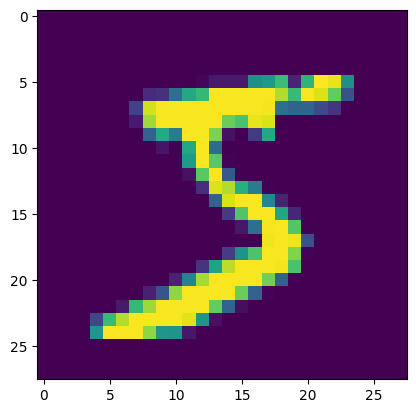

In [14]:
img = mnist_trainset.__getitem__(0)[0]
print(f"Initial image shape {img.shape}")
plt.imshow(img.permute(1, 2, 0))

In [15]:
# Now add the the learnable class embedding and position embeddings
# From start to positional encoding: All in 1 cell

# 1. Set patch size
patch_size = 4

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {img.shape}")
height, width = img.shape[1], img.shape[2]

# 3. Get image tensor and add batch dimension
x = img.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patchify = PatchEmbedding(in_channels=img.shape[0],
                          patch_size=patch_size,
                          embedding_dim=4*4*img.shape[0])

# 5. Pass image through patch embedding layer
patch_embedding = patchify(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.rand(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.rand(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable


# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([1, 28, 28])
Input image with batch dimension shape: torch.Size([1, 1, 28, 28])
Patching embedding shape: torch.Size([1, 49, 16])
Class token embedding shape: torch.Size([1, 1, 16])
Patch embedding with class token shape: torch.Size([1, 50, 16])
Patch and position embedding shape: torch.Size([1, 50, 16])


In [16]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?
        
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [17]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )
    
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [18]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim, # Hidden size D from Table 1 for ViT-Base
                 num_heads, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
    # 5. Create a forward() method  
    def forward(self, x):
        
        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x 
        
        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x 
        
        return x

In [19]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size, # Training resolution from Table 3 in ViT paper
                 in_channels, # Number of channels in input image
                 patch_size, # Patch size
                 num_classes,
                 embedding_dim, # Hidden size D from Table 1 for ViT-Base
                 num_heads, # Heads from Table 1 for ViT-Base
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:float=0.1 # Dropout for patch and position embeddings
        ):
        super().__init__() # don't forget the super().__init__()!
        
        # 3. Make the image size is divisble by the patch size 
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    # 11. Create a forward() method
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1) 
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)
        
        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x       

In [20]:
# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
model = ViT(
    num_classes=len(mnist_trainset.classes),
    img_size=img.shape[1],
    in_channels=img.shape[0],
    patch_size=4,
    embedding_dim=4*4*img.shape[0],
    num_heads=4
).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
# model training 
model.train()

for epoch in range(10):
    
    epoch_loss = 0
    epoch_accuracy = 0
    i = 0
    for i, (images, labels) in enumerate(train_dataloader):

        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        output = model(images)
        
        # Calculate loss
        loss = loss_function(output, labels)
        
        # Releasing the cache
        optimizer.zero_grad() 
        
        # Backward Pass
        loss.backward()

        # Update model parameter
        optimizer.step()

        # accummulate the loss and accuracy for each epoch
        epoch_loss += loss.item()
        epoch_accuracy += calculate_accuracy(output, labels)

    print(f"Epoch: {epoch} - Loss: {epoch_loss} - Accuracy: {epoch_accuracy/(i+1)}")

Epoch: 0 - Loss: 4234.451646745205 - Accuracy: 0.48316666666666713
Epoch: 1 - Loss: 1743.741876333952 - Accuracy: 0.8154333333333307
Epoch: 2 - Loss: 1328.6663415916264 - Accuracy: 0.8588000000000008
Epoch: 3 - Loss: 1124.4296414609998 - Accuracy: 0.8815166666666673
Epoch: 4 - Loss: 1008.6280221678317 - Accuracy: 0.893400000000003
Epoch: 5 - Loss: 919.1233257781714 - Accuracy: 0.9032000000000001
Epoch: 6 - Loss: 839.4712770404294 - Accuracy: 0.9112833333333358
Epoch: 7 - Loss: 786.5366106107831 - Accuracy: 0.9170999999999995
Epoch: 8 - Loss: 730.296127141919 - Accuracy: 0.9236499999999993
Epoch: 9 - Loss: 679.7084869132377 - Accuracy: 0.9283999999999981


In [22]:
model.eval()
accuracy = 0
i = 0
for i, (images, labels) in enumerate(test_dataloader):

    images, labels = images.to(device), labels.to(device)

    # Forward pass
    output = model(images)

    # Accumulate accuracy
    accuracy += calculate_accuracy(output, labels)

# Print test accuracy
print(f"Test Accuracy: {accuracy / (i + 1)}")

Test Accuracy: 0.9520999999999971
